In [2]:
import pandas as pd
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.covariance import MinCovDet
%matplotlib inline

In [3]:
df = pd.read_csv('bank_new.csv')
print(df.shape)
df.head()

(27128, 16)


,id,age,job,marital,education,default,amount,housing,loan,contact,day,month,duration,campaign,previous,y
0,1,39,blue-collar,married,secondary,no,1756,yes,no,cellular,3,apr,370.055237,1,0,1
1,2,51,entrepreneur,married,primary,no,1443,no,no,cellular,18,feb,233.998933,10,0,1
2,3,36,management,single,tertiary,no,436,no,no,cellular,13,apr,NaN,1,2,0
3,4,63,retired,married,secondary,no,474,no,no,cellular,25,jan,252.525808,1,0,0
4,5,31,management,single,tertiary,no,354,no,no,cellular,30,apr,NaN,1,2,0


In [4]:
# まず、ダミー変数化をしたいが、文字列の列が複数あるので抜き出す。
str_col_name=['job','default','marital','education','housing','loan','contact','month']
str_df = df[str_col_name]
#複数列を一気にダミー変数化
str_df2=pd.get_dummies(str_df,drop_first=True)

num_df = df.drop(str_col_name,axis=1)#数値列を抜き出す
df2 = pd.concat([num_df,str_df2,str_df],axis=1)#結合(今後の集計の利便性も考慮してstr_dfも結合しておく)
df2.head()

,id,age,amount,day,duration,campaign,previous,y,job_blue-collar,job_entrepreneur,...,month_oct,month_sep,job,default,marital,education,housing,loan,contact,month
0,1,39,1756,3,370.055237,1,0,1,True,False,...,False,False,blue-collar,no,married,secondary,yes,no,cellular,apr
1,2,51,1443,18,233.998933,10,0,1,False,True,...,False,False,entrepreneur,no,married,primary,no,no,cellular,feb
2,3,36,436,13,NaN,1,2,0,False,False,...,False,False,management,no,single,tertiary,no,no,cellular,apr
3,4,63,474,25,252.525808,1,0,0,False,False,...,False,False,retired,no,married,secondary,no,no,cellular,jan
4,5,31,354,30,NaN,1,2,0,False,False,...,False,False,management,no,single,tertiary,no,no,cellular,apr


In [5]:
#訓練&検証データとテストデータに分割
train_val,test = train_test_split(df2,test_size=0.1,random_state=9)
train_val.head()

,id,age,amount,day,duration,campaign,previous,y,job_blue-collar,job_entrepreneur,...,month_oct,month_sep,job,default,marital,education,housing,loan,contact,month
13378,13379,46,0,10,378.293875,1,0,1,False,False,...,False,False,unemployed,no,married,tertiary,yes,no,cellular,jul
3800,3801,41,-333,30,300.845752,3,2,0,True,False,...,False,False,blue-collar,no,divorced,secondary,yes,no,cellular,jan
10398,10399,30,5389,6,159.053623,3,0,1,False,False,...,False,False,management,no,single,tertiary,no,no,cellular,aug
23401,23402,39,255,5,334.802583,1,0,0,False,False,...,False,False,management,no,single,tertiary,yes,no,sending _document,may
26223,26224,47,33,5,NaN,1,0,1,False,False,...,False,False,services,no,single,secondary,yes,no,cellular,may


In [6]:
#欠損値の確認
is_nan=train_val.isnull().sum()
#欠損が存在している列だけ表示
is_nan[is_nan>0]

duration    6331
dtype: int64

In [7]:
# 改善案1  欠損値の補完方法を線形回帰で行ってみる。

In [8]:
train_val.corr(numeric_only=True)['duration'].map(abs).sort_values(ascending=False)

duration                     1.000000
housing_yes                  0.556899
loan_yes                     0.372579
y                            0.277575
age                          0.207738
month_aug                    0.187310
month_may                    0.184593
marital_single               0.164614
previous                     0.143538
marital_married              0.115429
job_student                  0.107913
contact_sending _document    0.087863
education_tertiary           0.081769
job_blue-collar              0.080727
month_jun                    0.065998
month_oct                    0.052855
job_unknown                  0.046328
job_management               0.045735
job_unemployed               0.044179
month_mar                    0.043775
job_housemaid                0.039184
education_secondary          0.033989
job_retired                  0.033277
month_sep                    0.032082
amount                       0.030532
day                          0.023779
job_services

In [9]:
#特徴量の当たりがついた
#しかし、そもそもこの線形回帰は外れ値の影響を強く受けるので調べる。
num_df=train_val.drop(str_col_name,axis=1)
num_df=num_df.drop('id',axis=1)
num_df2=num_df.dropna()
num_df2

,age,amount,day,duration,campaign,previous,y,job_blue-collar,job_entrepreneur,job_housemaid,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
13378,46,0,10,378.293875,1,0,1,False,False,False,...,False,False,False,True,False,False,False,False,False,False
3800,41,-333,30,300.845752,3,2,0,True,False,False,...,False,False,True,False,False,False,False,False,False,False
10398,30,5389,6,159.053623,3,0,1,False,False,False,...,False,False,False,False,False,False,False,False,False,False
23401,39,255,5,334.802583,1,0,0,False,False,False,...,False,False,False,False,False,False,True,False,False,False
25158,52,556,13,231.375776,6,0,1,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25725,45,14,18,315.275502,9,5,0,False,False,False,...,False,False,False,False,False,False,True,False,False,False
9979,59,3694,5,395.617358,10,0,1,False,False,False,...,False,False,False,False,True,False,False,False,False,False
22584,33,-208,4,424.191814,3,1,0,True,False,False,...,False,False,False,False,False,False,True,False,False,False
501,55,4746,23,404.106909,3,0,1,False,False,False,...,False,False,False,False,False,False,True,False,False,False


In [10]:
mcd2 =MinCovDet(random_state=0,support_fraction=0.7)
mcd2.fit(num_df2)

MinCovDet(random_state=0, support_fraction=0.7)

In [11]:
dis =mcd2.mahalanobis(num_df2)
dis=pd.Series(dis)
dis

0         30.914718
1         78.512220
2         32.620429
3         14.752679
4         22.603732
            ...    
18079    140.822449
18080     59.752067
18081     19.462121
18082     30.973451
18083     11.850268
Length: 18084, dtype: float64

<Axes: >

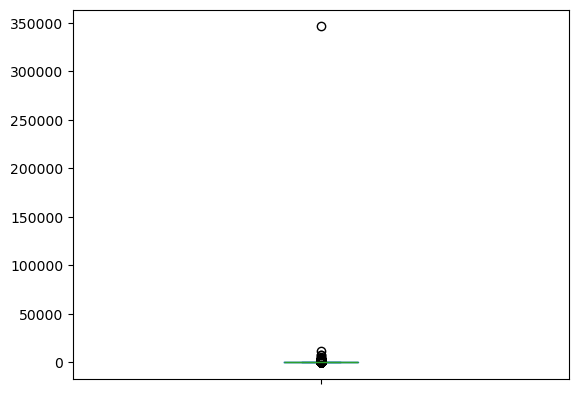

In [12]:
dis.plot(kind="box")

In [13]:
print(dis[0:3])#先頭は0番からのラベル
no=dis[dis>300000].index
no[0]

0    30.914718
1    78.512220
2    32.620429
dtype: float64


2561

In [14]:
dis

0         30.914718
1         78.512220
2         32.620429
3         14.752679
4         22.603732
            ...    
18079    140.822449
18080     59.752067
18081     19.462121
18082     30.973451
18083     11.850268
Length: 18084, dtype: float64

In [15]:
#先頭から2561番目が外れ値となる事が分かったので９章の付録で紹介したilocを利用する
no=num_df2.iloc[no[0]:(no[0]+1),:]
no

,age,amount,day,duration,campaign,previous,y,job_blue-collar,job_entrepreneur,job_housemaid,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
3140,40,543,2,1435.48804,2,275,0,False,False,False,...,False,True,False,False,False,False,False,False,False,False


In [16]:
train_val2 = train_val.drop(no.index)

In [17]:
train_val2.corr(numeric_only=True)['duration'].map(abs).sort_values(ascending=False)

duration                     1.000000
housing_yes                  0.559269
loan_yes                     0.374871
y                            0.279582
age                          0.208929
month_aug                    0.188017
month_may                    0.186111
marital_single               0.165022
marital_married              0.115441
job_student                  0.108389
previous                     0.102252
contact_sending _document    0.088832
education_tertiary           0.083440
job_blue-collar              0.081568
month_jun                    0.066075
month_oct                    0.053041
job_management               0.047512
job_unknown                  0.046511
job_unemployed               0.044287
month_mar                    0.043928
job_housemaid                0.039260
education_secondary          0.034967
job_retired                  0.033636
month_sep                    0.032166
amount                       0.030493
day                          0.022636
job_services

In [18]:
#monthはdurationに本質的に影響あるとは思えないので特徴量を
#housing_yes ,loan_yes,age,marital_single ,job_student    とする。（ｙは最終的な正解データなので除外）    

In [19]:
#欠損行を削除
not_nan_df = train_val2.dropna()
temp_t =not_nan_df['duration']
temp_x = not_nan_df[['housing_yes','loan_yes','age','marital_single' ,'job_student']]
# 線形回帰
from sklearn.linear_model import LinearRegression
model_liner = LinearRegression()

a,b,c,d= train_test_split(temp_x,temp_t,random_state=0,test_size=0.2)

#今回は予測させたいだけなので、標準化はしない
model_liner.fit(a,c)
print(model_liner.score(a,c),model_liner.score(b,d))

0.7271253237619109 0.7154980171798667


In [20]:
# コード修正(不要なので削除)
# tain_val2 = train_val.copy()

is_null=train_val2['duration'].isnull()
non_x=train_val2.loc[is_null,['housing_yes','loan_yes','age','marital_single','job_student']]
pred_d = model_liner.predict(non_x)
train_val2.loc[is_null,'duration']=pred_d

(24414, 48)

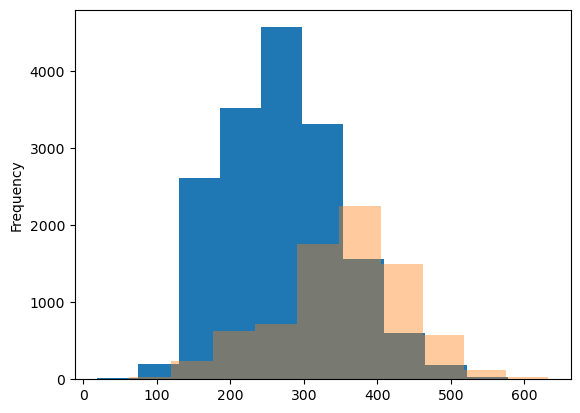

In [21]:
#ヒストグラムの確認
train_val2.loc[train_val['y']==0,"duration"].plot(kind="hist")
train_val2.loc[train_val['y']==1,"duration"].plot(kind="hist",alpha=0.4)
train_val2.shape
#y=1の方が、durationが大きい傾向がやっぱりありそう

In [22]:
#まず、さくっと学習できるようなlearn関数を定義する。
def learn(x,t,i):
    x_train,x_val,y_train,y_val = train_test_split(x,t,test_size=0.2,random_state=13)

    datas=[x_train,x_val,y_train,y_val]
    #不均衡データに対応できるように、class_weight引数も設定
    model = tree.DecisionTreeClassifier(random_state=i,max_depth=i,class_weight='balanced')
    model.fit(x_train,y_train)
    train_score=model.score(x_train,y_train)
    
    
    val_score=model.score(x_val,y_val)
    return train_score,val_score,model,datas

In [23]:
t =train_val2['y']
x = train_val2.drop(str_col_name,axis=1)
x =x.drop(['id','y','day'],axis=1)

In [24]:
#とりあえず、for文で様々な木の深さでの正解率を調べてみる
for i in range(1,15):
    s1,s2,model,datas = learn(x,t,i)
    print(i,s1,s2)

1 0.7436383185704777 0.7651034200286709
2 0.674517433823153 0.6807290600040958
3 0.7416926936664789 0.7569117345893918
4 0.6975065280835595 0.7034609870980955
5 0.7592545184578363 0.7653082121646528
6 0.7422047002201628 0.745033790702437
7 0.7774307511136143 0.7773909481875896
8 0.8082535456453842 0.7939791112021298
9 0.822180123905586 0.7999180831456072
10 0.843377195228099 0.8038091337292648
11 0.8587885924939839 0.7958222404259676
12 0.8744047923813425 0.7886545156665984
13 0.8949874558394347 0.792135981978292
14 0.9094260406533203 0.7911120212983821


In [25]:
#テストデータでも調べる
test2 = test.copy()
isnull=test2['duration'].isnull()
model_tree=tree.DecisionTreeClassifier(random_state=10,max_depth=10,class_weight="balanced")
if isnull.sum()>0:
    temp_x=test2.loc[isnull,['housing_yes','loan_yes','age','marital_single','job_student']]
    pred_d = model_liner.predict(temp_x)
    test2.loc[isnull,'duration']=pred_d
x_test = test2.drop(str_col_name,axis=1)
x_test =x_test.drop(['id','y','day'],axis=1)
y_test = test['y']

model.score(x_test,y_test)

0.7814227792112053

In [26]:
#9章の最後より若干低下している

In [27]:
#どのような間違い方をしているのか確認
s1,s2,model,datas = learn(x,t,9)

In [28]:
#訓練データでの予測結果と実際の値の2軸で個数集計flagがFalseならば、検証データで集計
def syuukei(model,datas,flag=False):
    if flag:
        pre=model.predict(datas[0])
        y_val=datas[2]
    else:
        pre=model.predict(datas[1])
        y_val=datas[3]
    data={
        "pred":pre,
        "true":y_val
    }
    tmp=pd.DataFrame(data)
    return tmp,pd.pivot_table(tmp,index="true",columns="pred",values="true",aggfunc=len)
tmp,a=syuukei(model,datas,False)
a

pred,0,1
true,,
0,2631,715
1,262,1275


In [29]:
#訓練データと検証データの間違い型の傾向を調べる

In [30]:
#値にばらつきが大きいので、標準化してもう一度グラフ化
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
tmp2=train_val2.drop(str_col_name,axis=1)
sc_data = sc.fit_transform(tmp2)
sc_df = pd.DataFrame(sc_data,columns=tmp2.columns,index=tmp2.index)

######挿入箇所#######
pre = model.predict(sc_df.drop(["id","day","y"],axis=1))
target = tmp2["y"]
true = (pre == target)
false = (pre!= target)
############

true_df=sc_df.loc[true]
false_df=sc_df.loc[false]
true_df

,id,age,amount,day,duration,campaign,previous,y,job_blue-collar,job_entrepreneur,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
3800,-1.244074,0.006333,-0.558245,1.700902,0.046425,0.080083,0.765240,-0.686092,1.898599,-0.186073,...,-0.069987,-0.250544,5.533927,-0.423782,-0.364411,-0.105947,-0.664296,-0.307335,-0.127246,-0.116515
23401,1.255816,-0.182325,-0.362602,-1.293495,0.422274,-0.557918,-0.305701,-0.686092,-0.526704,-0.186073,...,-0.069987,-0.250544,-0.180703,-0.423782,-0.364411,-0.105947,1.505353,-0.307335,-0.127246,-0.116515
3156,-1.326209,-0.936957,-0.105737,-1.652823,-1.471514,0.080083,-0.305701,-0.686092,-0.526704,-0.186073,...,-0.069987,-0.250544,-0.180703,2.359703,-0.364411,-0.105947,-0.664296,-0.307335,-0.127246,-0.116515
7545,-0.766440,1.138281,-0.227847,-1.652823,-0.768074,-0.557918,0.765240,-0.686092,-0.526704,-0.186073,...,-0.069987,3.991322,-0.180703,-0.423782,-0.364411,-0.105947,-0.664296,-0.307335,-0.127246,-0.116515
24823,1.437176,-0.559641,-0.263782,0.263591,1.183911,-0.557918,-0.305701,-0.686092,-0.526704,-0.186073,...,-0.069987,-0.250544,-0.180703,2.359703,-0.364411,-0.105947,-0.664296,-0.307335,-0.127246,-0.116515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5014,-1.089241,-1.219944,-0.431809,0.622919,-1.588017,0.080083,-0.305701,-0.686092,-0.526704,-0.186073,...,-0.069987,-0.250544,-0.180703,2.359703,-0.364411,-0.105947,-0.664296,-0.307335,-0.127246,-0.116515
22584,1.151617,-0.748299,-0.516654,-1.413271,1.411676,0.080083,0.229769,-0.686092,1.898599,-0.186073,...,-0.069987,-0.250544,-0.180703,-0.423782,-0.364411,-0.105947,1.505353,-0.307335,-0.127246,-0.116515
23166,1.225844,-0.276654,-0.346298,-0.574840,-1.153459,-0.557918,2.371650,-0.686092,-0.526704,-0.186073,...,-0.069987,-0.250544,-0.180703,-0.423782,-0.364411,-0.105947,1.505353,-0.307335,-0.127246,-0.116515
20828,0.927658,-0.559641,-0.238495,1.581126,-0.336500,-0.238917,-0.305701,-0.686092,1.898599,-0.186073,...,-0.069987,-0.250544,-0.180703,-0.423782,-0.364411,-0.105947,1.505353,-0.307335,-0.127246,-0.116515


<Axes: >

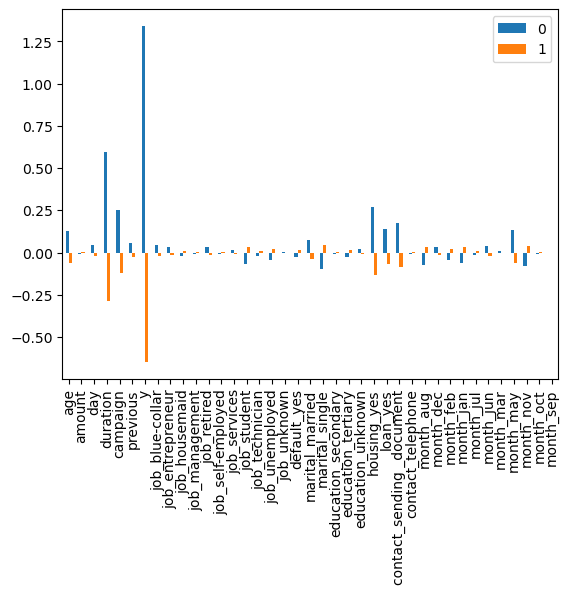

In [31]:
temp2=pd.concat([false_df.mean()["age":],true_df.mean()["age":]],axis=1)
temp2.plot(kind='bar')

In [32]:
print(train_val2.groupby('loan')['y'].mean())
print(train_val2.groupby('housing')['y'].mean())

loan
no     0.300210
yes    0.424328
Name: y, dtype: float64
housing
no     0.217959
yes    0.400940
Name: y, dtype: float64


In [33]:
train_val3=train_val2.copy()
train_val3['du*hou']=train_val3['duration']*train_val3['housing_yes']
train_val3['du*loan']=train_val3['duration']*train_val3['loan_yes']
train_val3['du*age']=train_val3['duration']*train_val3['age']

In [34]:
t =train_val3['y']

monthcol=['month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep']
jobcol=['job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown']
x = train_val3.drop(str_col_name,axis=1)
x = x.drop(jobcol,axis=1)

x = x.drop(monthcol,axis=1)
x =x.drop(['id','y','day'],axis=1)
x.columns

Index(['age', 'amount', 'duration', 'campaign', 'previous', 'job_blue-collar',
       'default_yes', 'marital_married', 'marital_single',
       'education_secondary', 'education_tertiary', 'education_unknown',
       'housing_yes', 'loan_yes', 'contact_sending _document',
       'contact_telephone', 'du*hou', 'du*loan', 'du*age'],
      dtype='object')

In [35]:
#とりあえず、for文で様々な木の深さでの正解率を調べてみる
for i in range(5,15):
    s1,s2,model,datas = learn(x,t,i)
    print(i,s1,s2)

5 0.7585377092826788 0.7648986278926889
6 0.7422559008755312 0.7440098300225272
7 0.7811171983001383 0.7792340774114274
8 0.8061543187752803 0.7876305549866885
9 0.8267369822333726 0.801146835961499
10 0.8407147611489427 0.7978701617857874
11 0.8552045466181967 0.7911120212983821
12 0.8780912395678665 0.7988941224656974
13 0.8984691004044851 0.7982797460577514
14 0.9142901029133172 0.7978701617857874


In [36]:
s1,s2,model,datas = learn(x,t,9)
tmp,a=syuukei(model,datas,False)
a

pred,0,1
true,,
0,2653,693
1,278,1259


In [37]:
pd.Series(model.feature_importances_,index=x.columns)

age                          0.103160
amount                       0.019240
duration                     0.522389
campaign                     0.141550
previous                     0.012433
job_blue-collar              0.000689
default_yes                  0.001352
marital_married              0.001845
marital_single               0.001906
education_secondary          0.001850
education_tertiary           0.001379
education_unknown            0.000689
housing_yes                  0.020159
loan_yes                     0.018217
contact_sending _document    0.019211
contact_telephone            0.000493
du*hou                       0.034961
du*loan                      0.043253
du*age                       0.055223
dtype: float64

In [38]:
i=9
model = tree.DecisionTreeClassifier(random_state=i,max_depth=i,class_weight="balanced")
model.fit(x,t)

DecisionTreeClassifier(class_weight='balanced', max_depth=9, random_state=9)

In [39]:
#テストデータでも調べる
test2 = test.copy()
isnull=test['duration'].isnull()
if isnull.sum()>0:
    temp_x=test2.loc[isnull,['housing_yes','loan_yes','age','marital_single','job_student']]
    pred_d = model_liner.predict(temp_x)
    test2.loc[isnull,'duration']=pred_d

test2['du*hou']=test2['duration']*test2['housing_yes']
test2['du*loan']=test2['duration']*test2['loan_yes']
test2['du*age']=test2['duration']*test2['age']

x_test = test2.drop(str_col_name,axis=1)
x_test = x_test.drop(jobcol,axis=1)
x_test = x_test.drop(monthcol,axis=1)
x_test =x_test.drop(['id','y','day'],axis=1)
y_test = test['y']
x_test.columns
model.score(x_test,y_test)

0.7913748617766311

In [40]:
# 直観的に考えて、9章では、housingとloanで集計しており、今回の線形回帰では、それらの列も含まれているから、
# durationの性能はよりよくなるはず、でも全体のモデルの正解率は1%ほど低下している

#原因の仮説⇒ １．現状の線形回帰だと訓練&検証に過学習してしまい、テストデータにフィットしない。
                 #（そもそもテストデータではdurationがあまり関係していない？？）
#            2. 純粋な決定木の限界？

#            3. 現在考慮していない特徴量ももっとしっかりした方が良いのか？？

#次以降の章で仮説1,2について検討できるので、次章に続く。